# **Анализ данных с датчика температуры оборудования из датасета NAB**

In [1]:

%%capture
!pip install etna[all] -U

In [2]:
import torch
import random

import pandas as pd
import numpy as np

from etna.datasets.tsdataset import TSDataset
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform, LagTransform, LinearTrendTransform, StandardScalerTransform
from etna.metrics import SMAPE, MAPE, MAE
from etna.analysis import plot_backtest
from etna.models import SeasonalMovingAverageModel
from etna.models.nn import DeepARModel, RNNModel
from etna.models.nn.utils import PytorchForecastingDatasetBuilder

from pytorch_forecasting.data import GroupNormalizer

## **Данные**

## **Визуализация**

In [3]:
# Загрузка данных и первоначальная визуализация
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import numpy as np

RANDOM_STATE = 42

file = 'machine_temperature_system_failure.csv'
df = pd.read_csv(file, parse_dates=['timestamp'], index_col='timestamp')

print(df.head())

                         value
timestamp                     
2013-12-02 21:15:00  73.967322
2013-12-02 21:20:00  74.935882
2013-12-02 21:25:00  76.124162
2013-12-02 21:30:00  78.140707
2013-12-02 21:35:00  79.329836


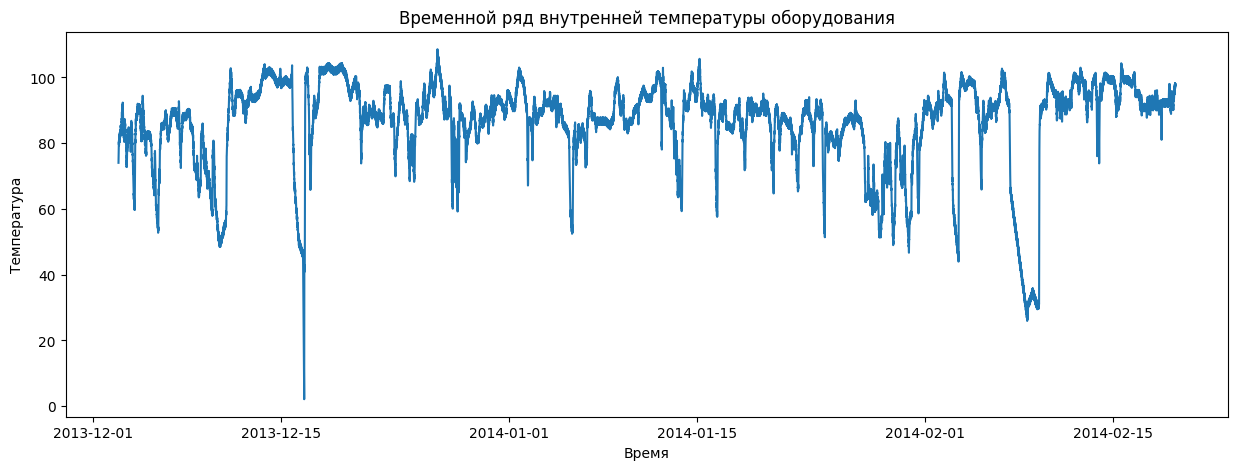

In [4]:
# Визуализация временного ряда
# На основе визуализированных данных можно сказать о тренде, сезонности и стационарности ряда.
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['value'])
plt.title('Временной ряд внутренней температуры оборудования')
plt.xlabel('Время')
plt.ylabel('Температура')
plt.show()

**По графику можно сказать, что наблюдается стабильность значения температуры  слеовательно нет явного восходящего или низходящего трендов. На графике не наблюдается сезонности. Ровное значение относительно времени указывает на стационарность ряда.**

## **Сделайте train/test split**

In [7]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

print(f'Размер обучающей выборки: {len(train)}')
print(f'Размер тестовой выборки: {len(test)}')

Размер обучающей выборки: 18156
Размер тестовой выборки: 4539


На мой взгляж релевантной метрикой здесь будет МАЕ так как она менее чувтстительна к выбросам.

## **Прогнозирование**

## **Бейзлайн**

Построение бейзлайна в формате скользящего среднего, так как оно сглаживает временные ряды и получает значения, соответствующие влиянию главных факторов.

In [9]:
sma_forecast = test.copy()
sma_forecast['sma'] = train[['value']].rolling(288,min_periods=1,step=4).mean().loc[:, 'value'].to_list()

# Вычисление MAE
from sklearn.metrics import mean_absolute_error

mae_sma = mean_absolute_error(test['value'], sma_forecast['sma'])
print(f'MAE наивного прогноза: {mae_sma:.4f}')

MAE наивного прогноза: 15.7778


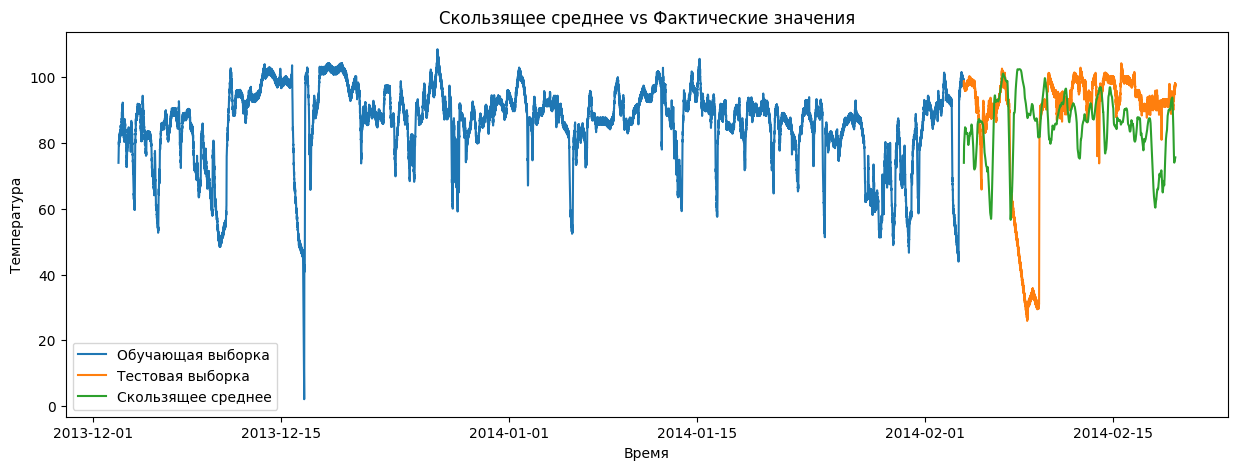

In [10]:
#Визуализация результатов работы модели
plt.figure(figsize=(15, 5))
plt.plot(train.index, train['value'], label='Обучающая выборка')
plt.plot(test.index, test['value'], label='Тестовая выборка')
plt.plot(test.index, sma_forecast['sma'], label='Скользящее среднее')
plt.title('Скользящее среднее vs Фактические значения')
plt.xlabel('Время')
plt.ylabel('Температура')
plt.legend()
plt.show()

Из графика видим, что скользящее среднее сглаживает резкие колебания, которые присутствуют в тестовой выборке. Оно просто продолжает прогнозировать возможное значение. Особенно это заметно, когда происходят резкие изменения в тестовой выборке.

Визуально видно, что скользящее среднее немного отличается от фактических значений, но достаточно близко к ним.

Вывод: среднее скользящее в данном случае прекрасно подходит для прогнозирования, так как оно сглаживает колебания, имеющие место в тестовой выборке. Тем самым, прогноз можно назвать достаточно достоверным и точным.**Текст, выделенный полужирным шрифтом**

## **Статистическая модель**

### Проведите тест Дики-Фуллера и интерпретируйте **результаты**

Цель теста: Проверить стационарность временного ряда. Нулевая гипотеза теста Дики-Фуллера заключается в том, что ряд нестационарен (имеет единичный корень).

In [11]:
def adf_test(series, title=''):

    print(f'Результаты теста Дикки-Фуллера {title}:')
    dftest = adfuller(series, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

    if dftest[1] < 0.05:
        print("Ряд стационарен, нулевая гипотеза отвергается.")
    else:
        print("Ряд нестационарен, нулевая гипотеза не отвергается.")
    print("\n")

# Проведение теста Дики-Фуллера для обучающей выборки
adf_test(train['value'], title='Обучающая выборка')

# Проведение теста Дики-Фуллера для тестовой выборки
adf_test(test['value'], title='Тестовая выборка')

Результаты теста Дикки-Фуллера Обучающая выборка:
Test Statistic                -7.835696e+00
p-value                        6.123823e-12
#Lags Used                     2.300000e+01
Number of Observations Used    1.813200e+04
Critical Value (1%)           -3.430711e+00
Critical Value (5%)           -2.861699e+00
Critical Value (10%)          -2.566855e+00
dtype: float64
Ряд стационарен, нулевая гипотеза отвергается.


Результаты теста Дикки-Фуллера Тестовая выборка:
Test Statistic                   -2.091108
p-value                           0.248105
#Lags Used                        6.000000
Number of Observations Used    4532.000000
Critical Value (1%)              -3.431794
Critical Value (5%)              -2.862178
Critical Value (10%)             -2.567110
dtype: float64
Ряд нестационарен, нулевая гипотеза не отвергается.




Из-за нескольких больших колебаний на тестовой выборке получаем противоположные результаты теста Дики-Фуллера для обучающей и тестовой выборки.

Ряд является нестационарным, что требует его преобразования для применения моделей, требующих стационарности.

### **Постройте графики ACF/PACF и проанализируйте их, сделайте предположения о наличии/отсутствии сезонности**

<Figure size 1500x500 with 0 Axes>

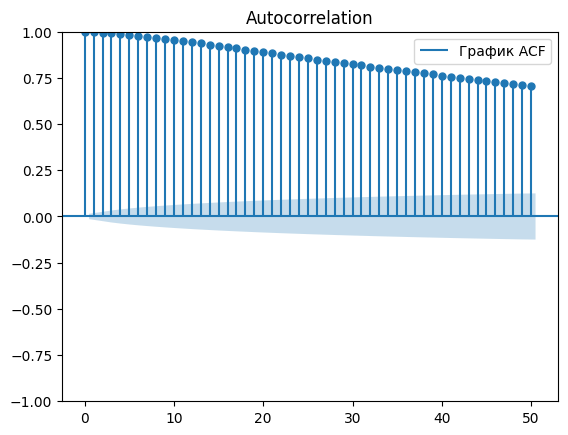

<Figure size 1500x500 with 0 Axes>

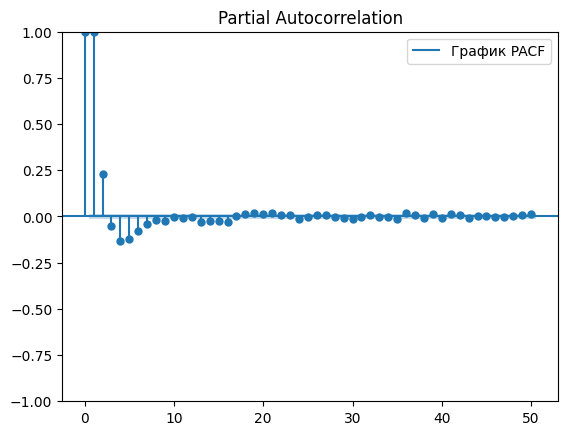

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15, 5))
plot_acf(train['value'], lags=50)
plt.legend(['График ACF'])
plt.show()

plt.figure(figsize=(15, 5))
plot_pacf(train['value'], lags=50, method='ywm')
plt.legend(['График PACF'])
plt.show()

Наличие автокорреляции на многих лагах в ACF: Это говорит о том, что значения временного ряда на текущем шаге сильно зависят от предыдущих значений. Такое поведение характерно для временных рядов с трендом или сезонностью.

Первый лаг в PACF: Значительная частичная автокорреляция на первом лаге говорит о том, что модель AR(1) (авторегрессия первого порядка) может быть подходящей для описания временного ряда. Значимые пики на малых лагах указывают на возможность использования AR-компоненты в модели



### **Проведем необходимые на наш взгляд преобразования для придания ряду стационарности (дифференцирование / сезонное дифференцирование)**

In [13]:
# Дифференцирование временного ряда
diff_train = train['value'].diff().dropna()
diff_test = test['value'].diff().dropna()

# Проведение теста Дики-Фуллера на дифференцированных данных
adf_test(diff_train, title='Дифференцированная обучающая выборка')
adf_test(diff_test, title='Дифференцированная тестовая выборка')

Результаты теста Дикки-Фуллера Дифференцированная обучающая выборка:
Test Statistic                   -27.018065
p-value                            0.000000
#Lags Used                        21.000000
Number of Observations Used    18133.000000
Critical Value (1%)               -3.430711
Critical Value (5%)               -2.861699
Critical Value (10%)              -2.566855
dtype: float64
Ряд стационарен, нулевая гипотеза отвергается.


Результаты теста Дикки-Фуллера Дифференцированная тестовая выборка:
Test Statistic                  -21.262721
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    4532.000000
Critical Value (1%)              -3.431794
Critical Value (5%)              -2.862178
Critical Value (10%)             -2.567110
dtype: float64
Ряд стационарен, нулевая гипотеза отвергается.




### **Проверьте стационарность полученного ряда с тестом Дики-Фуллера и визуализацией ACF/PACF**

<Figure size 1500x500 with 0 Axes>

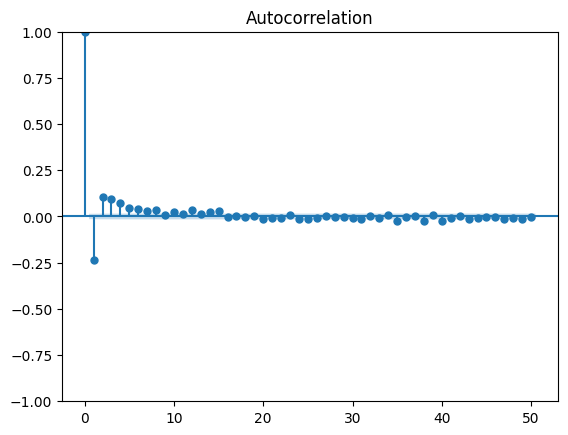

<Figure size 1500x500 with 0 Axes>

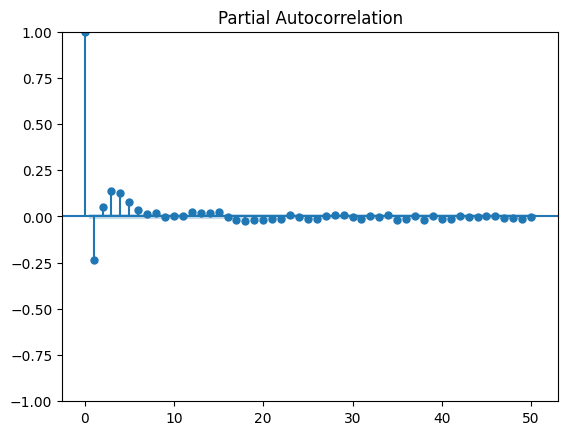

In [14]:
plt.figure(figsize=(15, 5))
plot_acf(diff_train, lags=50)
plt.show()

plt.figure(figsize=(15, 5))
plot_pacf(diff_train, lags=50, method='ywm')
plt.show()


ACF: Быстрое затухание автокорреляции подтверждает стационарность.

PACF: Наличие значимых лагов на малых порядках поможет в выборе параметров модели ARIMA.

### **Обучите модель ARIMA или SARIMA для прогнозирования значений ряда, подобрав оптимальные параметры**

In [15]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_order = None
best_mdl = None

for param in pdq:
    try:
        tmp_mdl = sm.tsa.ARIMA(train['value'], order=param).fit()
        tmp_aic = tmp_mdl.aic
        if tmp_aic < best_aic:
            best_aic = tmp_aic
            best_order = param
            best_mdl = tmp_mdl
    except:
        continue

print(f'Лучшая модель ARIMA{best_order} с AIC = {best_aic}')

Лучшая модель ARIMA(2, 0, 2) с AIC = 52539.95715432847


In [16]:
# Обучение модели с найденными параметрами
model = sm.tsa.ARIMA(train['value'], order=best_order)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                18156
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -26263.979
Date:                Mon, 23 Dec 2024   AIC                          52539.957
Time:                        08:00:31   BIC                          52586.798
Sample:                             0   HQIC                         52555.354
                              - 18156                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         85.7214      1.540     55.671      0.000      82.703      88.739
ar.L1          1.7864      0.011    161.200      0.000       1.765       1.808
ar.L2         -0.7879      0.011    -71.268      0.0

In [17]:
# Прогнозирование и оценка качества
forecast = model_fit.forecast(steps=len(test))
mae_arima = mean_absolute_error(test['value'], forecast)
print(f'MAE модели ARIMA: {mae_arima:.2f}')

MAE модели ARIMA: 13.46


### **Визуализируйте результаты работы модели, произведите замеры качества модели ARIMA (или SARIMA)**

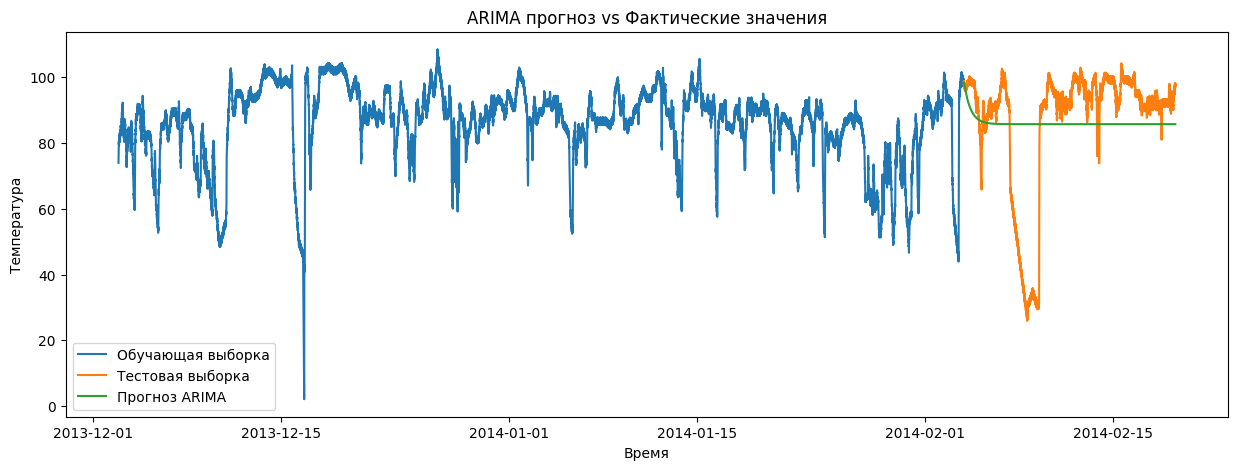

In [18]:

plt.figure(figsize=(15, 5))
plt.plot(train.index, train['value'], label='Обучающая выборка')
plt.plot(test.index, test['value'], label='Тестовая выборка')
plt.plot(test.index, forecast, label='Прогноз ARIMA')
plt.title('ARIMA прогноз vs Фактические значения')
plt.xlabel('Время')
plt.ylabel('Температура')
plt.legend()
plt.show()

Из графика работы модели видно, что прогноз модели (зеленая линия) отклоняется от фактических данных (оранжевая линия) и остается относительно плоским. Это вероятно всего произошло ввиду выбросов имеющихся во временном ряду.

В целом, поведение модели на графике показывает результаты хуже по сравнению с скользящим средним, это указывает на ее ограниченную способность адаптироваться к данным с резкими изменениями, что требует пересмотра подхода или модели.

## **Классическая модель**

### **Используйте Feature-Engineering для создания признаков (лаги, скользящие статистики, признаки даты/времени, etc)**

In [19]:
for i in range(1, 4):
    df[f'lag_{i}'] = df['value'].shift(i)

df['rolling_mean'] = df['value'].shift(1).rolling(window=3).mean()

df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

df.dropna(inplace=True)

train_feat = df.iloc[:train_size]
test_feat = df.iloc[train_size:]

Лаги: Добавляем предыдущие значения ряда в качестве признаков, что помогает модели учитывать автокорреляцию.

Скользящее среднее: Помогает сгладить ряд и выявить локальные тенденции.

Признаки даты: Час и день недели могут влиять на температуру, поэтому их включение может улучшить модель.

Удаление пропущенных значений: После сдвигов появляются NaN, которые необходимо удалить.

Цель Feature Engineering: Создать информативные признаки для улучшения работы моделей машинного обучения.

### **На полученном наборе данных обучите случайный лес или градиентный бустинг**

In [20]:
from sklearn.ensemble import RandomForestRegressor

features = ['lag_1', 'lag_2', 'lag_3', 'rolling_mean', 'hour', 'dayofweek']
X_train = train_feat[features]
y_train = train_feat['value']
X_test = test_feat[features]
y_test = test_feat['value']

rf = RandomForestRegressor(random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Прогнозирование
rf_pred = rf.predict(X_test)

# Оценка качества
mae_rf = mean_absolute_error(y_test, rf_pred)
mse_rf = mean_squared_error(y_test, rf_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, rf_pred)

print(f'MAE модели случайного леса: {mae_rf:.2f}')
print(f'MSE модели случайного леса: {mse_rf:.2f}')
print(f'RMSE модели случайного леса: {rmse_rf:.2f}')
print(f'R² модели случайного леса: {r2_rf:.2f}')

MAE модели случайного леса: 0.87
MSE модели случайного леса: 1.31
RMSE модели случайного леса: 1.14
R² модели случайного леса: 1.00


### **Визуализируйте результаты работы модели, произведите замеры качества модели**

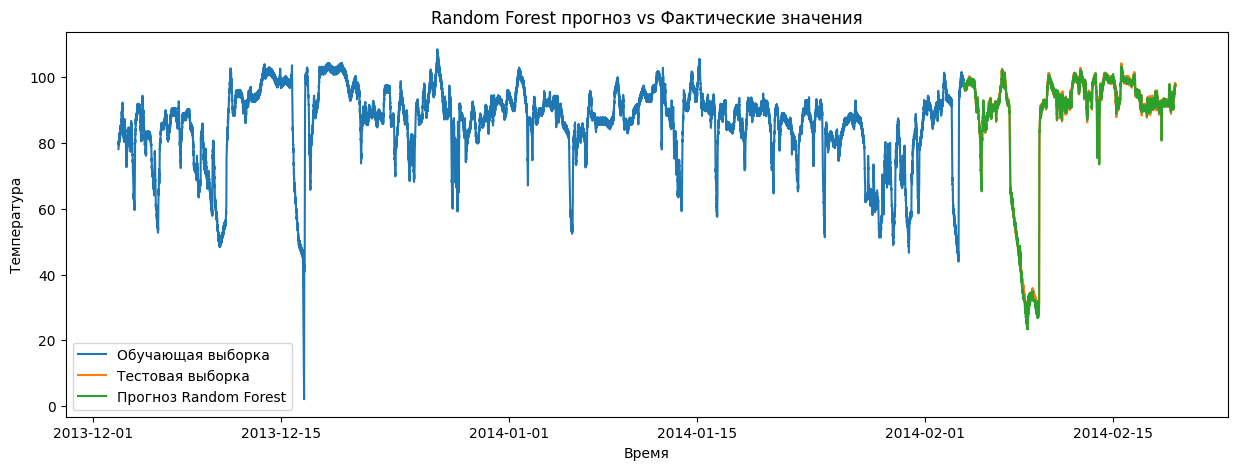

In [21]:
plt.figure(figsize=(15, 5))
plt.plot(train_feat.index, train_feat['value'], label='Обучающая выборка')
plt.plot(test_feat.index, test_feat['value'], label='Тестовая выборка')
plt.plot(test_feat.index, rf_pred, label='Прогноз Random Forest')
plt.title('Random Forest прогноз vs Фактические значения')
plt.xlabel('Время')
plt.ylabel('Температура')
plt.legend()
plt.show()

Анализ графика:

Модель случайного леса отлично справляется с прогнозированием, учитывая нелинейности и сложные зависимости.

Видно, что модель адаптируется к изменениям в данных лучше, чем любая из стационарных моделей.

MAE (Mean Absolute Error): Показывает среднюю абсолютную разницу между предсказанными и фактическими значениями.

MSE (Mean Squared Error): Квадраты ошибок усиливают влияние больших отклонений, что важно, если большие ошибки более критичны.

RMSE (Root Mean Squared Error): Корень из MSE, имеет ту же размерность, что и исходные данные, и более интерпретируем.

R² (Коэффициент детерминации): Значение от 0 до 1, где 1 означает идеальное соответствие модели данным.